In [1]:
%reload_ext autoreload
%autoreload 2

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from sktime.transformations.series.boxcox import LogTransformer
from pmdarima.arima.utils import ndiffs, nsdiffs, diff

from hydra import compose, initialize, core
from omegaconf import OmegaConf

from src.custom_utils import S3Helper
from src.eda import ExploratoryDataAnalyzer

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='down_sampling')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## Data

In [3]:
s3_helper = S3Helper()

data = s3_helper.read_parquet(obj_key=config['input_key'])
data['service_date'] = pd.to_datetime(data['service_date'])
data.drop_duplicates(keep='first', inplace=True)

data = data.loc[:, ['service_date', 'bus', 'rail_boardings']]

## Downsampling

For medium and longer term forecasting horizons, we consider downsampling (decreasing the frequency from daily to monthly) by way of aggregation. This decision is grounded on several considerations:

* **Computational resources**: The sheer volume of daily data over extended periods can impose significant computational demands. Downsampling to a monthly frequency reduces the dataset size, thereby decreasing the computational load. This not only expedites the processing time but also minimizes the risk of computational bottlenecks, enabling the use of more sophisticated forecasting models that may otherwise be computationally prohibitive.

* **Model Stability and Performance**: Models trained on high-frequency data can sometimes be overly sensitive to minor fluctuations, leading to overfitting. By focusing on monthly aggregates, models can better capture the more stable and relevant structural relationships in the data, enhancing the robustness and predictive performance of the forecasts.

* **Practical Relevance**: For strategic planning and decision-making, monthly forecasts are often more actionable than daily predictions. They align better with business cycles and are typically the basis for setting performance targets and allocating resources.

* **Noise Reduction**: Daily data can often include a considerable amount of 'noise'—random fluctuations that can obscure underlying patterns. Aggregating data on a monthly basis helps in smoothing out these irregularities, allowing for a clearer identification of trends and seasonality which are crucial for accurate forecasting for longer-term horizons.

### Conditional Distributions of Bus Ride and Rail Boardings

To decide on the aggregation function to use for downsampling the daily observations--- median or mean--- we plot the conditional distributions of bus ridership and rail boardings given each month of each year over the sampling period:

In [14]:
eda_helper = ExploratoryDataAnalyzer(data=data)
eda_helper

Dropdown(description='Year:', index=19, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

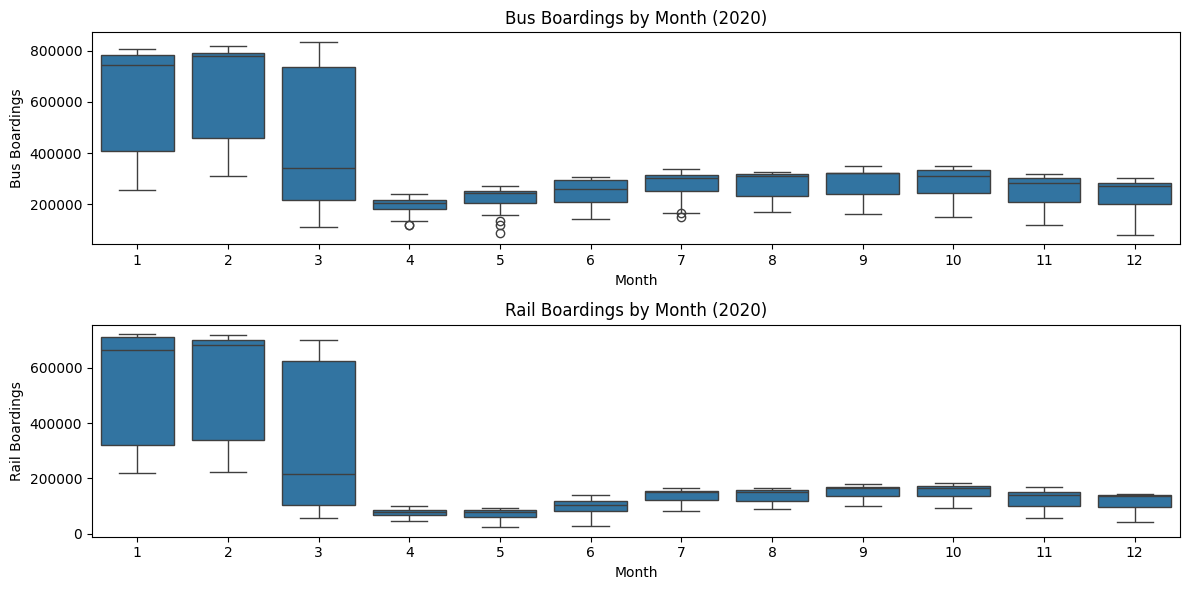

In [15]:
eda_helper.plot_monthly_distribution_by_year(
    selections=range(2001, 2023 + 1),
    fig_size=(12, 6)
)

Evidently, the monthly distributions are skewed; this is especially true for the pandemic years, but, even for non-Covid years, the skewness if noticeable. Therefore, using the median will be more robust than using the mean for aggregation.

### Resampling

In [5]:
data.set_index('service_date', inplace=True)
# Resample to monthly (Month End) 
data = data.resample('M').median()
data.reset_index(inplace=True)
data

,service_date,bus,rail_boardings
0,2001-01-31,953532.0,587052.0
1,2001-02-28,988407.5,601003.0
2,2001-03-31,1000946.0,600914.0
3,2001-04-30,947600.0,596461.5
4,2001-05-31,995884.0,602748.0
...,...,...,...
265,2023-02-28,453915.0,301171.0
266,2023-03-31,475520.0,320115.0
267,2023-04-30,459253.5,326873.0
268,2023-05-31,499608.0,356184.0


## ACF & PACF

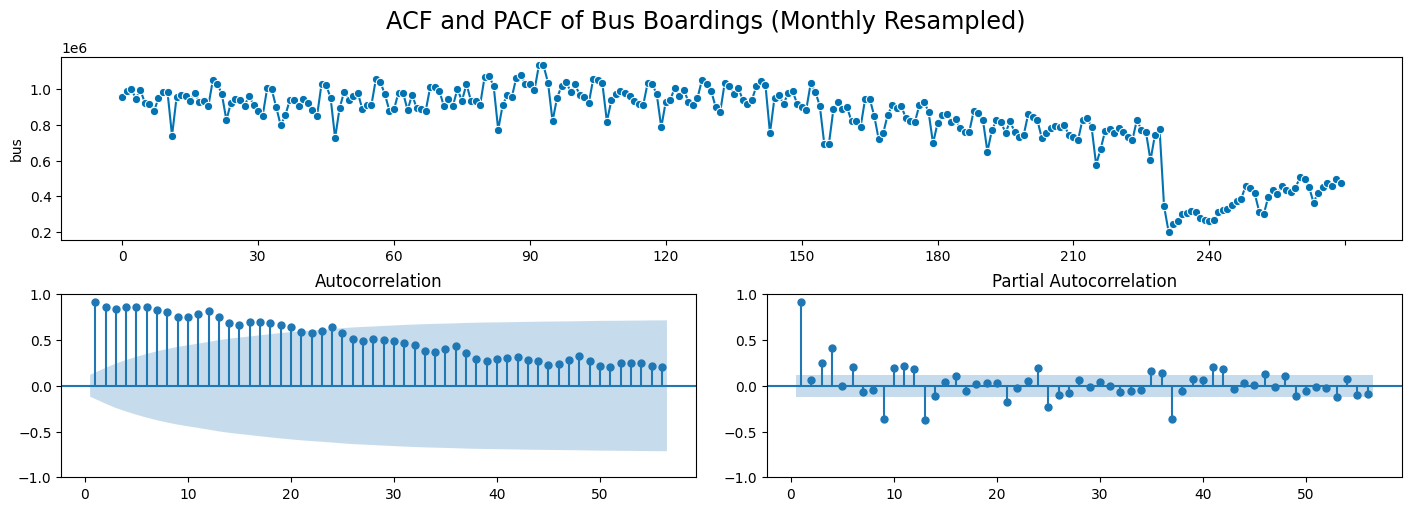

In [49]:
eda_helper = ExploratoryDataAnalyzer(data=data)

eda_helper.plot_correlations(
    series=data['bus'],
    lags=56,
    suptitle='ACF and PACF of Bus Boardings (Monthly Resampled)',
    fig_size=(14, 5)
)

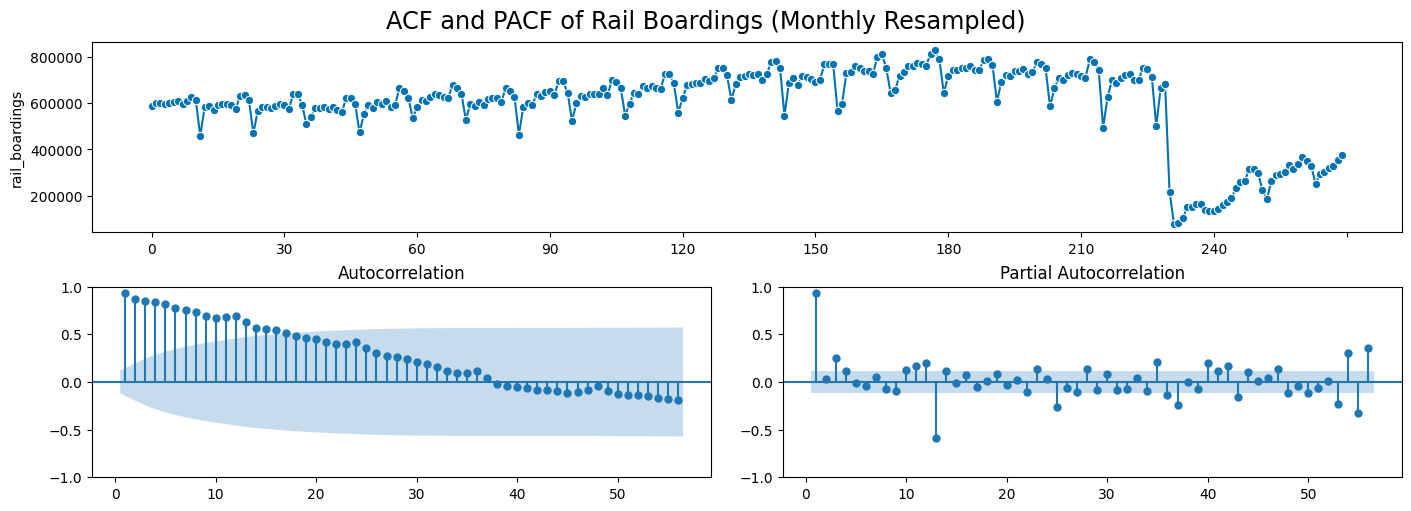

In [50]:
eda_helper.plot_correlations(
    series=data['rail_boardings'],
    lags=56,
    suptitle='ACF and PACF of Rail Boardings (Monthly Resampled)',
    fig_size=(14, 5)
)

* Based on these plots, we confirm our findings from the `eda.ipynb` notebook that the monthly time series are non-stationary with annual seasonality (significant coefficients at seasonal lags 12 and 24 in the ACF).

* We can also argue that there seems to be a decay (tailing off) in the the PACF plots of both series at each seasonal lags 12, 24, 48, etc., suggesting `ARMA(p, q)(P, Q)` processes. 

* In addition, the Covid-19 pandemic resulted in a structural break in both series, which we must at least address before any forecasting.